#  Daisyworld without radiative equilibrium

In this notebook we will review the modified Daisyworld model created by Nevson et. al (1999). These authors changed the original model in order to make it a little bit more realistic.The original Dasyworld model assumes that Daisywolrd is in a perfect radiative balance. This means that the incoming radiation to the planet is exactly equal to the outgoing radiation. However, this is an unrealistic assumption. As the authors of this paper say: the "Earth is well known to be in imperfect balance, both spatially and temporally, between incoming solar and outgoing longwave radiation".

In order to add this feature to the model, these authors replaced the equation 4 of the original Daisywolrd notebook, with an ordinary differential equation that describes the chage in the effective temperature of the Earth. So the original equation 4 becomes:

\begin{equation} \tag{4}
c_p (\frac{dT_e}{dt}) = SL(1 - A) - \sigma {T_e}^4
\end{equation}

where $c_p$ ($ erg K^-1 cm^{-2}$) is a measure of the thermal inertial of the planet, $T_e (K)$ is the effective temperature, $S$ = $2.89x10^{13} erg year^{-1} cm^{-2}$ is the total radiation reaching the planet, L is a dimensionless number that controls the radiation of the sun, $\sigma =$ 1789 $erg K^{-4} cm^{-2} year{-1}$ is Stefan’s constant for blackbody radiation, and $A$ is the total albedo of the planet. I t is important to note that the authors modified the units of some constants to measure time in years.

Let's solve this model to see how the introduction of the new equation affects the behavior of the daisies. 

In [78]:
import numpy as np
import matplotlib.pyplot as plt

class Unbalanced_Daisywolrd():
    q = 2064250710.0 #20 # Heat Transfer Coefficient
    sigma = 1789  #Stefan-Boltzman Constant
    S = 2.89e+13  # Solar constant
    L = 1 # Solar luminosity constant
    
    def __init__(self
                ,death_rate =.3 #death rate of daysies
                ,albedo_w=0.75  #white daysies albedo
                ,albedo_g=0.5  #Free ground albedo      
                ,albedo_b=0.25  #Black daysies albedo
                ,area_w= 0.3 # Fraction area of white daisies
                ,area_b= 0.3 # Fraction area of black daisies
                ,cp = 3e+13 # thermal inertia
                ):
        'Initilize all the constants and variables'
        self.death_rate = death_rate
        self.albedo_w = albedo_w
        self.albedo_g = albedo_g
        self.albedo_b = albedo_b
        self.area_w = area_w
        self.area_b = area_b
        self.area_g = 1 - self.area_b - self.area_w # Equation 2
        self.cp = cp
        self.albedo_total = self.area_w * self.albedo_w + self.area_b * self.albedo_b + self.area_g * self.albedo_g
        self.Te = ((self.S * self.L * (1- self.albedo_total) / self.sigma) ** 0.25)- 273 #Equation 4
        self.Tw = (self.q*(self.albedo_total - self.albedo_w) + (self.Te +273)**4 )**.25 -273
        self.Tb = (self.q*(self.albedo_total - self.albedo_b)+ (self.Te +273)**4 )**.25 -273
        self.Bw = 1 -0.003265 * ((22.5-self.Tw)**2) #Equation 2
        self.Bb = 1 -0.003265 * ((22.5-self.Tb)**2) #Equation 2
        
    def update_area_g(self):
        'Calclate area of free ground'
        self.area_g = 1 - self.area_b - self.area_w 
        return self.area_g
    
    def update_albedo_total(self):
        self.albedo_total = self.area_w * self.albedo_w + self.area_b * self.albedo_b + self.area_g * self.albedo_g

    
    def update_global_temp(self, h):
        self.Te += h * (self.S * self.L * (1- self.albedo_total) - self.sigma * (self.Te + 273)**4) / self.cp 

    
    def update_daisies_temp(self):
        self.Tw = (self.q*(self.albedo_total - self.albedo_w) + (self.Te +273)**4 )**.25 -273
        self.Tb = (self.q*(self.albedo_total - self.albedo_b)+ (self.Te +273)**4 )**.25 -273
        #Linear aproximation case (q = 20)
        #self.Tw = self.q*(self.albedo_total-self.albedo_w)+ self.Te 
        #self.Tb = self.q*(self.albedo_total-self.albedo_b)+ self.Te 
    
    def update_growth_rate(self):
        self.Bw = 1 -0.003265 * ((22.5-self.Tw)**2)
        self.Bb = 1 -0.003265 * ((22.5-self.Tb)**2)
    
    
    def solve_model(self, iteartions = 12000, h = 0.1, store_values = False):
        'Solve equation 1 with euler method and recalculate all other variables'
        AW, AB, AG, TW, TB, TE = ([],[],[],[],[],[])
        for i in range(iteartions):
            self.area_w += h * self.area_w * (self.Bw * self.area_g -self.death_rate)
            self.area_b += h * self.area_b * (self.Bb * self.area_g -self.death_rate)
            self.update_area_g()
            self.update_albedo_total()
            self.update_global_temp(h)
            self.update_daisies_temp()
            self.update_growth_rate()
            if store_values:
                AW.append(self.area_w)
                AB.append(self.area_b)
                AG.append(self.area_g)
                TW.append(self.Tw)
                TB.append(self.Tb)
                TE.append(self.Te) 
        if store_values:
            self.AW = AW
            self.AB = AB
            self.AG = AG
            self.TW = TW
            self.TB = TB
            self.TE = TE
    
    def plot_model(self):
        fig = plt.figure()
        plt.plot(self.AB, 'k', linewidth=3, label='Black')
        plt.plot(self.AW, 'g',linewidth=3,label='White')
        
        
    
    def change_luminosity(self, L, iterations = 12000, h = 0.1):
        '''
        Change the sola luminosity in the model
        INPUT:
            self: Daisywolrd class
            L (lIST): list describing change in luminosity.
        '''
        #iteration parameters
        n = len(L)
        # lists to store values
        change_lum_TE, change_lum_AW, change_lum_AB, change_lum_AG = ([],[],[],[])
        # initial values
        area_w, area_b, albedo_w, albedo_b, albedo_g, death_rate =\
        self.area_w, self.area_b, self.albedo_w, self.albedo_b, self.albedo_g, self.death_rate
        for i in range(n):
            model = Unbalanced_Daisywolrd(area_w=area_w, area_b = area_b)
            model.L = L[i]
            model.solve_model(iterations, h)
            change_lum_AW.append(model.area_w)
            change_lum_AB.append(model.area_b)
            change_lum_AG.append(model.area_g)
            change_lum_TE.append(model.Te)
        self.change_lum_TE = np.array(change_lum_TE)
        self.change_lum_AW = np.array(change_lum_AW)
        self.change_lum_AB = np.array(change_lum_AB)
        self.change_lum_AG= np.array(change_lum_AG)
        self.L = L
        self.no_life_Te = (self.S * self.L * (1- 0.5) / self.sigma)**0.25-273
    
    def plot_change_lumonosity(self):
        fig, ax = plt.subplots()
        ax.plot(self.L, self.change_lum_AB, 'k', linewidth=3, label='Black')
        ax.plot(self.L, self.change_lum_AW, 'g',linewidth=3,label='White')
        #ax.plot(self.L, self.change_lum_AB + self.change_lum_AW, 'k--', linewidth=3, label='Sum')
        plt.xlabel('Solar Luminosity $L$', fontsize=18)
        plt.ylabel(r'Fraction area area_i', fontsize=18)
        plt.title('Figure 1', fontsize=20)
        plt.axis([0.4, 1.8, -0.1, 0.8])
        legend = ax.legend(loc=1, shadow=True)
        frame = legend.get_frame()
        frame.set_facecolor('0.90')
        # Set the fontsize
        for label in legend.get_texts():
            label.set_fontsize('large')
        for label in legend.get_lines():
            label.set_linewidth(1.5)  # the legend line width
        plt.show()
        
        fig, ax = plt.subplots()
        ax.plot(self.L, self.change_lum_TE, 'g', linewidth=3, label='T with daisies')
        ax.plot(self.L, self.no_life_Te , 'k--', linewidth=3, label='T without daisies')
        plt.xlabel('Solar Luminosity $L$', fontsize=18)
        plt.ylabel('$T $ [$^\circ C$]', fontsize=18)
        plt.title('Figure 2', fontsize=20)
        plt.axis([0.4, 1.6, -30, 70])
        legend = ax.legend(loc=4, shadow=True)
        frame = legend.get_frame()
        frame.set_facecolor('0.90')
        # Set the fontsize
        for label in legend.get_texts():
            label.set_fontsize('large')
        for label in legend.get_lines():
            label.set_linewidth(1.5)  # the legend line width
        plt.show()
            

        

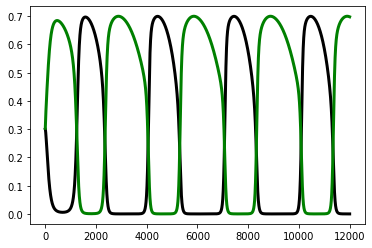

In [79]:
model = Unbalanced_Daisywolrd()
model.solve_model(store_values = True)
model.plot_model()

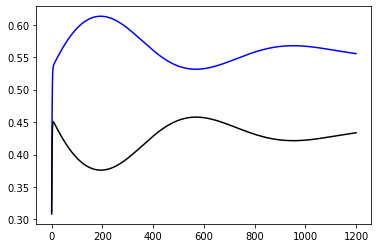

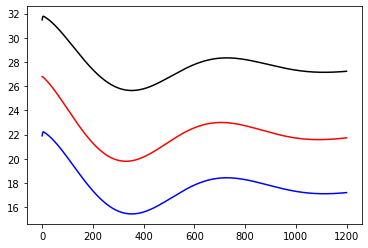

In [39]:
import matplotlib.pyplot as plt

model = Unbalanced_Daisywolrd(death_rate = 0.01)
iterations = 12000
h = 0.1

Aw, Ab, Ag, TW, TB, TE  = model.solve_model(iterations, h)
t =(np.arange(0, len(Aw)) / 10).tolist()

plt.figure()
plt.plot(t, Aw, 'b')
plt.plot(t, Ab, 'k')

plt.figure()
plt.plot(t, TW, 'b')
plt.plot(t, TB, 'k')
plt.plot(t, TE, 'r')

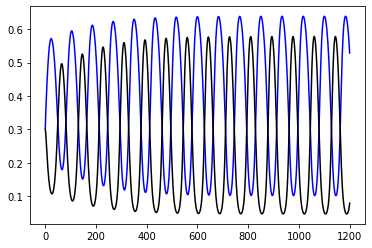

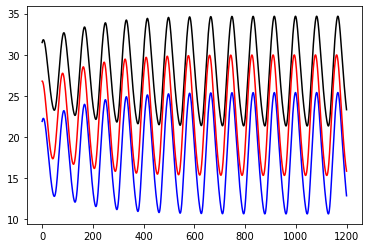

In [54]:
import matplotlib.pyplot as plt

model = Unbalanced_Daisywolrd(cp = 0.7e13)
iterations = 12000
h = 0.1

Aw, Ab, Ag, TW, TB, TE  = model.solve_model(iterations, h)
t =(np.arange(0, len(Aw)) / 10).tolist()

plt.figure()
plt.plot(t, Aw, 'b')
plt.plot(t, Ab, 'k')

plt.figure()
plt.plot(t, TW, 'b')
plt.plot(t, TB, 'k')
plt.plot(t, TE, 'r')

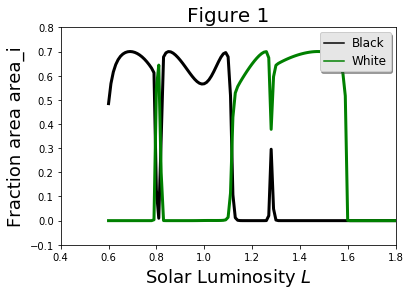

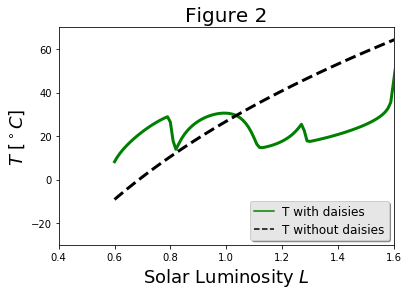

In [71]:
L = np.arange(0.6, 1.8, 0.01)
model = Unbalanced_Daisywolrd()
model.change_luminosity(L, iterations=5000)
model.plot_change_lumonosity()